# Load Packages

In [384]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import os
import scipy
import re

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import matplotlib.mlab as mlab

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout,LSTM,Embedding
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

import multiprocessing as mp
from joblib import Parallel, delayed
print("Number of processors: ", mp.cpu_count())

#import mutual_info

#mutual_info.test_mutual_information_2d()
import time

import datetime
from datetime import timedelta
from datetime import date
import pytz
import pickle

import bs4
from bs4 import BeautifulSoup
import requests

import nltk

from wordcloud import WordCloud, STOPWORDS


import torch
print(torch.__version__)

import random

Number of processors:  8
1.1.0


In [2]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daliangli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Collection

## Scrape a forum page

In [7]:
def insert_mystr_before_astr(orgstr,mystr,astr="?prune_day"):
    idx = orgstr.index(astr)
    return orgstr[:idx] + mystr + orgstr[idx:]

In [62]:
#We build tools to scrape a page of the cloudynights forum
#The input is a thread like 
#https://www.cloudynights.com/forum/67-refractors/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all
#The output is a list of urls

def soup_a_forum(url,n_pages = 4):
    #n_pages needs to be smaller than the total number of pages in this forum
    soups = []
    page = 1
    title = ""
    while page <= n_pages:
        time.sleep(2)
        if page==1: page_url = url
        else: page_url = insert_mystr_before_astr(orgstr=url,mystr="page-"+str(page),astr="?prune_day")
        fpage1 = requests.get(page_url)
        soup1 = BeautifulSoup(fpage1.content, 'html.parser')
        
        #new_title = soup1.find_all('title')[0].get_text()
        #if title == new_title: break
        #else: title = new_title
        
        soups.append(soup1)
        page += 1
    return soups
    

def from_a_soup_to_url(soup):
    element_list = soup.find_all(id=re.compile("tid-link-......"))
    return [element["href"] for element in element_list] 

def remove_from_list_if_contains_substring(orglist,substring):
    return [ele for ele in orglist if not substring in ele] 

def remove_from_list_if_contains_any_substring(orglist,substrings):
    result = []
    for ele in orglist:
        contains = False
        for substr in substrings:
            if substr in ele: contains = True
        if not contains: result.append(ele)
    return result 

In [17]:
forum_page_urls = ["https://www.cloudynights.com/forum/67-refractors/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/71-eyepieces/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/64-binoculars/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/69-cats-casses/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/66-mounts/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/68-reflectors/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/65-binoviewers/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all"
                  ]

In [18]:
forum_level_soup = [soup_a_forum(forum_url,n_pages=5) for forum_url in forum_page_urls]

In [46]:
url_lists = [np.concatenate([from_a_soup_to_url(page) for page in forum]) for forum in forum_level_soup]

In [202]:
world_filters = ["-you","-we-","money","collection","guidelines","important","mod","how-to","to-improve","info",
                 "improvements","question","auction",
                 "apos-better",
                 "what-is-your","whats-in-your","show-us-your","have-you-found",
                 "post-a-pic","links-of-interest","policy","do-you-own","show-off","no-use","billp","myths-and-misconceptions",
                 "paracorr-settings","eyepiece-buyers-guide","identifying-eyepiece-aberrations","filters-buyers-guide",
                "clarifications","overlooking-the-obvious","most-beautiful","gems-best-of","vintage-and-classic","tinkering",
                 "home-built","collimated","complementary","resolving","birding","not-popular","scams","classical-cassegrain",
                 "focal-reducer","classic-cassegrain","new-scam","best-threads","duplicate","cables","is-soft","corrector",
                 "thermal-issues","collima","coma","make-a-reflector","best-25mm",
                ]

filtered_url_lists = [remove_from_list_if_contains_any_substring(url_list,world_filters) for url_list in url_lists]


In [206]:
#with open('filtered_url_lists', 'wb') as fp:
#    pickle.dump(filtered_url_lists, fp)
    


## Scrape a thread

In [ ]:
#Images not included, emojs not included, author identity not included

In [256]:
page = all_soups_s[0][0][0]

pec = page.find(class_="post entry-content ")

lpec = list(pec.children)

print([type(ele) for ele in lpec])
print([ele.name for ele in lpec])

type(lpec[0]) == bs4.element.NavigableString

[<class 'bs4.element.NavigableString'>, <class 'bs4.element.Comment'>, <class 'bs4.element.NavigableString'>, <class 'bs4.element.Tag'>, <class 'bs4.element.Tag'>, <class 'bs4.element.Tag'>, <class 'bs4.element.NavigableString'>, <class 'bs4.element.Tag'>, <class 'bs4.element.Tag'>, <class 'bs4.element.Tag'>, <class 'bs4.element.NavigableString'>, <class 'bs4.element.Tag'>, <class 'bs4.element.Tag'>, <class 'bs4.element.Tag'>, <class 'bs4.element.NavigableString'>, <class 'bs4.element.Tag'>, <class 'bs4.element.NavigableString'>]
[None, None, None, 'img', 'br', 'br', None, 'img', 'br', 'br', None, 'img', 'br', 'br', None, 'br', None]


True

In [432]:
def extract_title_from_thread_url(a_url):
    return a_url[a_url.index("-")+1:-1].replace("-"," ")

def soup_a_thread(url,n_pages = 30, wait_time = 1):
    soups = []
    page = 1
    title = ""
    while page <= n_pages:
        time.sleep(wait_time)
        if page==1: page_url = url
        else: page_url = url + "page-" + str(page)
        fpage1 = requests.get(page_url)
        soup1 = BeautifulSoup(fpage1.content, 'html.parser')
        
        new_title = soup1.find_all('title')[0].get_text()
        if title == new_title: break
        else: title = new_title
        
        soups.append(soup1)
        page += 1
    return soups

def post_entry_content_to_text(post_entry_content):
    content_list = list(post_entry_content.children)
    a_comment = ""
    for parts in content_list:
        if parts.name == 'p': a_comment+=". "+parts.get_text()
        elif type(parts) == bs4.element.NavigableString:a_comment+=". "+parts

    return text_cleaning(a_comment)

def text_cleaning(string):
    string += "Edited by"
    string = string[:string.index("Edited by")].replace("\xa0","").replace("\n","").replace("\t","").replace("\r","")
    return string.replace(" .","").lstrip(".").lstrip(" ").rstrip()

def all_comments_from_a_souped_thread(a_souped_thread):
    all_comments = []
    for page in a_souped_thread:
        page_contents = page.find_all(class_="post entry-content ")
        all_comments += [post_entry_content_to_text(a_content) for a_content in page_contents]
    return all_comments


def text_a_class_in_soup(soup,cls = 'post entry-content '):
    text_res = []
    contents = soup.find_all(class_ = cls)
    for content in contents:
        for parag in content.find_all('p'):
            text_res.append(parag.get_text())
    return text_res

def grab_a_thread(url,n_pages = 30):
    post_entry_text = []
    page = 1
    title = ""
    while page <= n_pages:
        time.sleep(1)
        if page==1: page_url = url
        else: page_url = url + "page-" + str(page)
        fpage1 = requests.get(page_url)
        soup1 = BeautifulSoup(fpage1.content, 'html.parser')
        
        new_title = soup1.find_all('title')[0].get_text()
        if title == new_title: break
        else: title = new_title
        
        post_entry_contents = soup1.find_all(class_ = 'post entry-content ')
        for content in post_entry_contents:
            for parag in content.find_all('p'):
                post_entry_text.append(parag.get_text())
        page += 1
    return post_entry_text

def nltk_sentiment(sentence):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [220]:
with open ('filtered_url_lists', 'rb') as fp:
     filtered_url_lists = pickle.load(fp)

filtered_url_lists_short = [url_list[:25] for url_list in filtered_url_lists] 

In [223]:
all_soups_s = []
for i,filtered_url_list_short in enumerate(filtered_url_lists_short):
    print("souping url list",i)
    all_soups_s.append([soup_a_thread(thread,n_pages = 50,wait_time = 0.8) for thread in filtered_url_list_short])

souping url list 0
souping url list 1
souping url list 2
souping url list 3
souping url list 4
souping url list 5
souping url list 6


In [234]:
#This generate a very big file but apparently works
#import sys

#sys.setrecursionlimit(40000)

#with open('all_soups_s', 'wb') as fp:
#     pickle.dump(all_soups_s, fp)

In [422]:
#all_soups_s[1].pop(0)
#filtered_url_lists[1].pop(0)
len(all_soups_s[1])

#with open('filtered_url_lists', 'wb') as fp:
#     pickle.dump(filtered_url_lists, fp)

24

In [434]:
title_lists = [[extract_title_from_thread_url(url) for url in url_list] for url_list in filtered_url_lists]

In [436]:
#Obtain the comments
comments_all_threads_all_forums = []
for i,soups in enumerate(all_soups_s):
    print("processing forum:",i)
    comments_all_threads_all_forums.append([all_comments_from_a_souped_thread(soup) for soup in soups])
    
with open('comments_all_threads_all_forums', 'wb') as fp:
     pickle.dump(comments_all_threads_all_forums, fp)

processing forum: 0
processing forum: 1
processing forum: 2
processing forum: 3
processing forum: 4
processing forum: 5
processing forum: 6


## Flair

In [ ]:
#

In [348]:
from flair.data import Sentence
from flair.models import TextClassifier

In [350]:
classifier = TextClassifier.load('en-sentiment')

2019-09-17 16:09:41,551 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/models-v0.4/classy-imdb-en-rnn-cuda%3A0/imdb-v0.4.pt not found in cache, downloading to /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpnmi8c4qq


100%|██████████| 1501979561/1501979561 [02:55<00:00, 8571210.85B/s] 

2019-09-17 16:12:37,280 copying /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpnmi8c4qq to cache at /Users/daliangli/.flair/models/imdb-v0.4.pt


2019-09-17 16:12:42,193 removing temp file /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpnmi8c4qq
2019-09-17 16:12:42,429 loading file /Users/daliangli/.flair/models/imdb-v0.4.pt


In [369]:
i_forum, i_thread = 1,9

print(filtered_url_lists_short[i_forum][i_thread])

string = comments_all_threads_all_forums[i_forum][i_thread][278]

print(string)

sentence = Sentence(string)
# predict NER tags
classifier.predict(sentence)

# print sentence with predicted labels
print(sentence.labels)

https://www.cloudynights.com/topic/497406-delite-eyepieces/
Tried them out today, and the coatings are the normal Televue level of excellence the eye relief is great, but there was a fair bit of pincushion to my eye (Danny heard me get the Televue guys spun up).... I personally will stick with 24 Panoptics, 17 UWANs, and smaller Naglers for my bino viewing, especially considering the price point. I think they are 100 dollars rich to the price point.. I did ask Al about my personal desire, which is a very high polish Televue quality Ortho, and the response I got was that the Delite would be a better eyepiece. That still doesnt satisfy the desire for an ultra high quality Ortho for me.... Maybe Zeiss, or Nikon, will introduce some..
[POSITIVE (0.6714904308319092)]


In [370]:
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

In [375]:
data = pd.read_csv("./spam.csv", encoding='latin-1').sample(frac=1).drop_duplicates()
data = data[['v1', 'v2']].rename(columns={"v1":"label", "v2":"text"})
 
data['label'] = '__label__' + data['label'].astype(str)
data.iloc[0:int(len(data)*0.8)].to_csv('train.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.csv', sep='\t', index = False, header = False);

In [376]:
corpus = NLPTaskDataFetcher.load_classification_corpus(Path('./'), 
                                                       test_file='test.csv', 
                                                       dev_file='dev.csv', 
                                                       train_file='train.csv')
word_embeddings = [WordEmbeddings('glove'), 
                   FlairEmbeddings('news-forward-fast'), 
                   FlairEmbeddings('news-backward-fast')]
document_embeddings = DocumentLSTMEmbeddings(word_embeddings, 
                                             hidden_size=512, 
                                             reproject_words=True, 
                                             reproject_words_dimension=256)
classifier_c = TextClassifier(document_embeddings, 
                            label_dictionary=corpus.make_label_dictionary(), 
                            multi_label=False)
trainer = ModelTrainer(classifier_c, corpus)
trainer.train('./', max_epochs=10)

2019-09-17 16:45:41,591 Reading data from .
2019-09-17 16:45:41,592 Train: train.csv
2019-09-17 16:45:41,592 Dev: dev.csv
2019-09-17 16:45:41,593 Test: test.csv


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) load_classification_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:447: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:454: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:463: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.

2019-09-17 16:45:43,477 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmphn3cbiq8


100%|██████████| 160000128/160000128 [00:14<00:00, 11097825.79B/s]

2019-09-17 16:45:58,330 copying /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmphn3cbiq8 to cache at /Users/daliangli/.flair/embeddings/glove.gensim.vectors.npy


2019-09-17 16:45:58,750 removing temp file /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmphn3cbiq8
2019-09-17 16:45:59,188 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpqjg1freh


100%|██████████| 21494764/21494764 [00:01<00:00, 11747652.65B/s]

2019-09-17 16:46:01,433 copying /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpqjg1freh to cache at /Users/daliangli/.flair/embeddings/glove.gensim


2019-09-17 16:46:01,482 removing temp file /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpqjg1freh
2019-09-17 16:46:03,009 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmp6z3i603i


100%|██████████| 19689779/19689779 [00:02<00:00, 7451193.11B/s]

2019-09-17 16:46:06,120 copying /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmp6z3i603i to cache at /Users/daliangli/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt


2019-09-17 16:46:06,180 removing temp file /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmp6z3i603i
2019-09-17 16:46:06,654 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpu1e0gtiu


100%|██████████| 19689779/19689779 [00:01<00:00, 10798303.65B/s]

2019-09-17 16:46:08,926 copying /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpu1e0gtiu to cache at /Users/daliangli/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt


2019-09-17 16:46:08,975 removing temp file /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpu1e0gtiu
2019-09-17 16:46:09,071 Computing label dictionary. Progress:


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 4135/4135 [00:00<00:00, 294731.02it/s]

2019-09-17 16:46:09,088 [b'ham', b'spam']
2019-09-17 16:46:09,092 ----------------------------------------------------------------------------------------------------
2019-09-17 16:46:09,093 Model: "TextClassifier(
  (document_embeddings): DocumentLSTMEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=256, bias=True)
    (rnn): GRU

2019-09-17 16:46:09,126 ----------------------------------------------------------------------------------------------------
2019-09-17 16:46:09,126 Model training base path: "."
2019-09-17 16:46:09,128 ----------------------------------------------------------------------------------------------------
2019-09-17 16:46:09,129 Device: cpu
2019-09-17 16:46:09,129 ----------------------------------------------------------------------------------------------------
2019-09-17 16:46:09,130 Embeddings storage mode: cpu
2019-09-17 16:46:09,139 ----------------------------------------------------------------------------------------------------
2019-09-17 16:46:12,210 epoch 1 - iter 0/130 - loss 0.59381700 - samples/sec: 135.63
2019-09-17 16:46:35,184 epoch 1 - iter 13/130 - loss 0.30352486 - samples/sec: 18.14
2019-09-17 16:47:02,593 epoch 1 - iter 26/130 - loss 0.25514138 - samples/sec: 15.20
2019-09-17 16:47:32,988 epoch 1 - iter 39/130 - loss 0.22209295 - samples/sec: 13.71
2019-09-17 16:48:

2019-09-17 16:55:56,625 BAD EPOCHS (no improvement): 2
2019-09-17 16:55:56,627 ----------------------------------------------------------------------------------------------------
2019-09-17 16:55:56,835 epoch 7 - iter 0/130 - loss 0.02646148 - samples/sec: 2017.77
2019-09-17 16:56:03,086 epoch 7 - iter 13/130 - loss 0.02856470 - samples/sec: 67.24
2019-09-17 16:56:08,159 epoch 7 - iter 26/130 - loss 0.02509655 - samples/sec: 82.87
2019-09-17 16:56:12,508 epoch 7 - iter 39/130 - loss 0.03312939 - samples/sec: 96.84
2019-09-17 16:56:17,920 epoch 7 - iter 52/130 - loss 0.03504161 - samples/sec: 77.61
2019-09-17 16:56:22,575 epoch 7 - iter 65/130 - loss 0.04045209 - samples/sec: 90.41
2019-09-17 16:56:27,391 epoch 7 - iter 78/130 - loss 0.04247086 - samples/sec: 87.47
2019-09-17 16:56:32,619 epoch 7 - iter 91/130 - loss 0.04253095 - samples/sec: 80.44
2019-09-17 16:56:36,931 epoch 7 - iter 104/130 - loss 0.04375991 - samples/sec: 97.75
2019-09-17 16:56:42,631 epoch 7 - iter 117/130 - loss

/anaconda3/lib/python3.7/site-packages/torch/serialization.py:574: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


2019-09-17 17:00:15,094 0.9865	0.9865	0.9865
2019-09-17 17:00:15,095 
MICRO_AVG: acc 0.9733 - f1-score 0.9865
MACRO_AVG: acc 0.9423 - f1-score 0.96975
ham        tp: 447 - fp: 4 - fn: 3 - tn: 63 - precision: 0.9911 - recall: 0.9933 - accuracy: 0.9846 - f1-score: 0.9922
spam       tp: 63 - fp: 3 - fn: 4 - tn: 447 - precision: 0.9545 - recall: 0.9403 - accuracy: 0.9000 - f1-score: 0.9473
2019-09-17 17:00:15,096 ----------------------------------------------------------------------------------------------------


{'test_score': 0.9865,
 'dev_score_history': [0.9671,
  0.971,
  0.9052,
  0.9787,
  0.9749,
  0.9749,
  0.9787,
  0.9807,
  0.9807,
  0.971],
 'train_loss_history': [0.14997153353089324,
  0.0778302174455558,
  0.06650013614875766,
  0.05652217348106205,
  0.05270936368570591,
  0.05005810968577862,
  0.04154881249593857,
  0.042908469698606774,
  0.03684169547632336,
  0.03604475988361698],
 'dev_loss_history': [tensor(0.0923),
  tensor(0.0944),
  tensor(0.3914),
  tensor(0.0677),
  tensor(0.0775),
  tensor(0.0715),
  tensor(0.0640),
  tensor(0.0710),
  tensor(0.0676),
  tensor(0.1088)]}

In [377]:
i_forum, i_thread = 1,9

print(filtered_url_lists_short[i_forum][i_thread])

string = comments_all_threads_all_forums[i_forum][i_thread][278]

print(string)

sentence = Sentence(string)
# predict NER tags
classifier_c.predict(sentence)

# print sentence with predicted labels
print(sentence.labels)

https://www.cloudynights.com/topic/497406-delite-eyepieces/
Tried them out today, and the coatings are the normal Televue level of excellence the eye relief is great, but there was a fair bit of pincushion to my eye (Danny heard me get the Televue guys spun up).... I personally will stick with 24 Panoptics, 17 UWANs, and smaller Naglers for my bino viewing, especially considering the price point. I think they are 100 dollars rich to the price point.. I did ask Al about my personal desire, which is a very high polish Televue quality Ortho, and the response I got was that the Delite would be a better eyepiece. That still doesnt satisfy the desire for an ultra high quality Ortho for me.... Maybe Zeiss, or Nikon, will introduce some..
[ham (0.9998044371604919)]


## Hand labeling data

In [438]:
comments_all_threads_all_forums[0][0]

['No, it\'s not an inflammation of your Takahashi!   Instead, I picked up a used FS-102 on AMart and will be doing visual comparisons against my SV-105T as soon as I can.  The Tak should arrive today/tomorrow.  I have a MT Pro and I\'ll see if I can mount both scopes together for doing side-by-sides!     Only issue is that the FS has only 1.25" visual back and I only have a 2" diagonal.   Oh well, I might have to view straight through to compare.   Stay tuned.. pics will be provided when I can..',
 'Resistance is futile.........halt and be converted!. Rex.',
 'How does the FS-102 only have an 1.25" visual back? Even my Tak Sky 90 had the 2" focuser with an 1.25" adapter. You are gonna love the veiw through a Fluorite doublet Rob. There is indeed something special to the view and a slight contrast advantage. With the warmer image due to only two elements, planetary viewing is particularly satisfying and very 3-D like with binoviewers. I have no doubt you will see a difference...enjoy an

In [448]:
#Select subset for hand labeling
hand_labeled_sample = []

for j,forum in enumerate(comments_all_threads_all_forums):
    #print("forum", j)
    for i in range(10):
        #print(len(forum[i]))
        current_samples = random.sample(forum[i], 10)
        for sample in current_samples:
                hand_labeled_sample.append([title_lists[j][i],sample])

In [449]:
len(hand_labeled_sample)

700

In [450]:
pd.DataFrame(hand_labeled_sample).to_csv('data1.csv', index = True, header = False)

## Tests

In [252]:
comments_all_threads = [all_comments_from_a_souped_thread(soup) for soup in soups]
sentiment_all_threads = [np.array([nltk_sentiment(comment)['compound'] for comment in comments]) 
                         for comments in comments_all_threads]

In [278]:
#ids_to_delete = [7,10,13,14,15]

#for i,ids in enumerate(ids_to_delete): del useful_threads[ids-i] 
#for i,ids in enumerate(ids_to_delete): del comments_all_threads[ids-i]  
#for i,ids in enumerate(ids_to_delete): del sentiment_all_threads[ids-i]  
#for i,ids in enumerate(ids_to_delete): del hours[ids-i] 

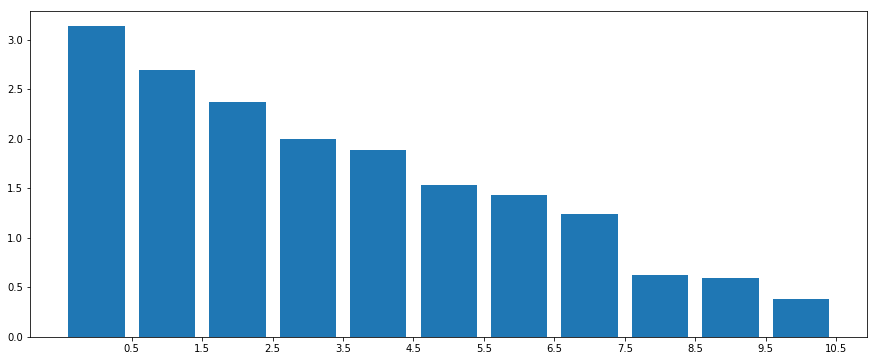

In [289]:
sorted_hours = np.sort(hours)[::-1]

x = np.arange(len(sorted_hours))
plt.bar(x, height= sorted_hours)
plt.xticks(x+.5)
plt.show()

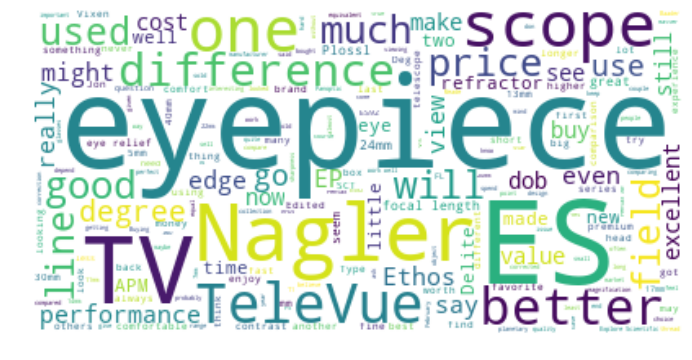

In [285]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(" ".join(comments_all_threads[-5]))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [265]:
def thread_statistics(all_comments_in_a_thread):
    total_string = "".join(all_comments_in_a_thread)
    return total_string.count(" ")
    
hours = [thread_statistics(thread)/250/60 for thread in comments_all_threads]

hours[7]

0.0

In [272]:
soups[0][0].find_all(class_="post entry-content ")

[<div class="post entry-content " itemprop="commentText">
 <!--cached-Thu, 05 Sep 2019 07:50:18 +0000--><p>ANYBODY HAVE ONE OF THESE NIKON NAV 17 HW with EiC-14  102 deg AFOV, OR HAD A CHANCE TO LOOK THROUGH ONE?  WHAT WERE THE VIEWS LIKE?</p>
 <br/>
 </div>, <div class="post entry-content " itemprop="commentText">
 <!--cached-Thu, 05 Sep 2019 07:50:18 +0000--><p>Just got mine about four hour ago.</p>
 <p> </p>
 <p>It's excellent. I'm finding that the 102 degrees is slightly easier to take in than the 100 degrees in the 17 ethos. It also appears to be very sharp indeed, but it is early days for making comparisons.</p>
 <p> </p>
 <p>The views appear equally sharp at 14mm as they are at 17.</p>
 <br/>
 </div>, <div class="post entry-content " itemprop="commentText">
 <!--cached-Thu, 05 Sep 2019 07:50:18 +0000--><p>It is an awesome eyepiece - flat flat flat across the entire field (ap178/tmb175/tec180 refractors). The best view I have had of the double cluster - unforgettable. Go get one.

In [271]:
soups[7][0].find_all(class_="post entry-content ")

[<div class="post entry-content " itemprop="commentText">
 <!--cached-Thu, 05 Sep 2019 08:21:10 +0000-->I got a letter from VernonScope yesterday. It did not say "don't tell anyone", so I'm telling.<br/><br/>Don Yeier is issuing a limited run of 50th Anniversary Brandon sets (limited to 100 sets). Six Brandons (6,8,12,16,24,32mm), gold anodized, in the fancy presentation case (which I can tell you is *very* nice). This is the same set I have, except mine are black, and these don't seem to have eyecups (but I could be wrong about that). <br/><br/>The price is VERY good. If you're contemplating spending Ethos-type money on eyepieces, look into a set of Brandons instead. They won't be available forever, and I'd bet this set won't last long at all.<br/><br/>Brandons are the *only* all-American-made eyepieces (optics, housing, everything), and are among the very finest eyepieces you can get. Eventually Don will retire, and Brandons will either disappear or the brand name will get bought up 

In [267]:
comments_all_threads[7]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [241]:
#a_soup = soup_a_thread("https://www.cloudynights.com/topic/550599-new-es-62-degree-line/")
all_comments_ES62 = all_comments_from_a_souped_thread(a_soup)
sentiments_ES62 = np.array([nltk_sentiment(comment)['compound'] for comment in all_comments_ES62])

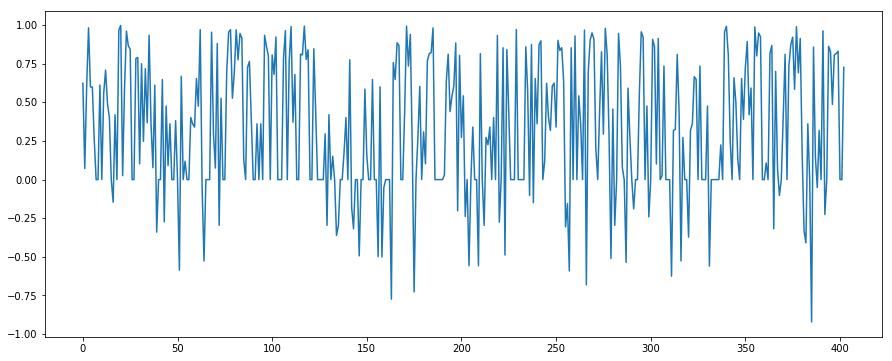

In [290]:
plt.plot(sentiments_ES62)

In [294]:
for i in range(len(all_comments_ES62)):
    if sentiments_ES62[i] <-0.2:
        print(i)
        print(sentiments_ES62[i])
        print(all_comments_ES62[i])

39
-0.34
. Yes, I could pick them up but they were attached to the display bench with a short metal wire so, aside from the weight, it was difficult to judge anything else. The black ring at the bottom of the barrel is possibly part of the anti-theft lock: there weren't any filters attached to it that I remember.. 
Edited by Marcsabb, 22 September 2016 - 11:30 AM.

43
-0.2732
. No information yet.  Still waiting for field stop widths, exact eye reliefs, weights, element and group counts.
51
-0.5859
. Except they say 1.25", which means 62 degrees is wrong...   .  . Obviously, it can't be both 1.25 and 62.  One of the two numbers is a "cut and haste" error.  I was simply pointing out there is another potential explanation.  I've seen plenty of 1.25 40mm plossls labeled as 52s when they can't be...
64
-0.5267
. So are these eyepieces actually going to be available in 2 days?  There is still nothing anywhere about them.  No pictures other than those posted on this thread.  No specs. .  . J

In [297]:
i=391
print(sentiments_ES62[i])
print(all_comments_ES62[i])

0.9631
. https://explorescien...2-32mm-eyepiece. and length 101mm, weight 419.6g, field stop 33.6mm, eye relief 22.2mm. In my f/7 refractor, it was sharp to about the 50° field point and the last 6° on each side with a fair amount of astigmatism.. The 31mm Hyperion deteriorated at about 10-11° from the edge of the field, making the center 50° fairly sharp.. So they are fairly equivalent but for the fact the Hyperion is 10° wider in apparent field (38mm field stop). The ES has noticeably more eye relief..  . Which one is appropriate will depend a lot on the focal length of the scope.. In my 714mm refractor, True fields are 2.7° and 3.0° respectively, which covers the same objects quite well.. But if the f/7 scope were an 8". then true fields would be 1.35° and 1.53° respectively and you might want to go for the wider true field for larger objects.. 
Edited by Starman1, 06 August 2017 - 03:28 PM.



In [292]:
sentiments_ES62.shape

(403,)